<h1 span style="text-align:center;color:mediumvioletred">Corn Disease Classification</h1>

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = 224
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

### Creating tf dataset

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "corn_disease",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 3852 files belonging to 4 classes.


In [4]:
class_names = dataset.class_names
class_names

['Corn___Common_Rust',
 'Corn___Gray_Leaf_Spot',
 'Corn___Healthy',
 'Corn___Northern_Leaf_Blight']

In [5]:
len(dataset)

121

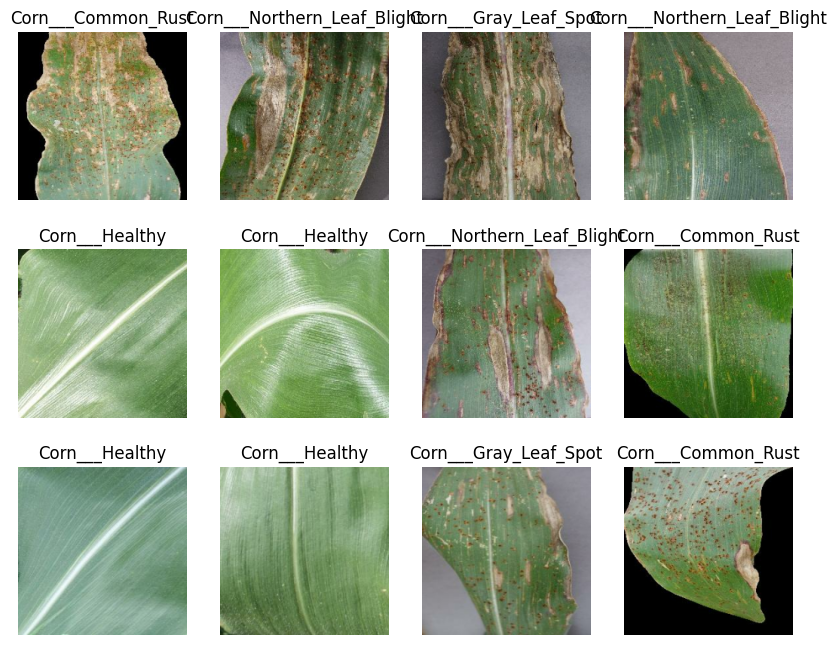

In [6]:
plt.figure(figsize=(10,8))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

### Splitting dataset
    80% ==> training
    20% ==> 10% validation, 10% test

In [7]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=1000):
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=8)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [8]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [9]:
print(len(train_ds), len(val_ds), len(test_ds))

96 12 13


### Data Preprocessing

In [10]:
train_ds = train_ds.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)

In [11]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [12]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.1)
])

### Model Training

In [13]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4

In [20]:
model = models.Sequential([
    #Input Layer
    layers.Input(shape=input_shape),
    #Preprocessing
    resize_and_rescale,
    data_augmentation,
    #CNN Layers
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    #Flatten
    layers.Flatten(),
    #Dense Layers
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [21]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                 

In [22]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Save a model at the end of every epoch
checkpoint = ModelCheckpoint(
    filepath='checkpoints/model_epoch_{epoch:02d}.h5',  # Save each epoch
    save_weights_only=False,  # False = save full model (arch + weights)
    save_freq='epoch',
    verbose=1
)

# Stop early if no improvement for 10 epochs, restore the best model
early_stop = EarlyStopping(
    monitor='val_accuracy',       # metric to watch
    patience=15,                   # wait 10 epochs without improvement
    restore_best_weights=True,     # bring back the best model
    verbose=1
)

In [23]:
# Train with callbacks
history = model.fit(
    train_ds,
    epochs=50,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds,
    callbacks=[checkpoint, early_stop]
)

Epoch 1/50
96/96 [==============================] - ETA: 0s - loss: 0.8170 - accuracy: 0.6504
Epoch 1: saving model to checkpoints\model_epoch_01.h5
96/96 [==============================] - 65s 635ms/step - loss: 0.8170 - accuracy: 0.6504 - val_loss: 0.3679 - val_accuracy: 0.8411
Epoch 2/50
96/96 [==============================] - ETA: 0s - loss: 0.3737 - accuracy: 0.8431
Epoch 2: saving model to checkpoints\model_epoch_02.h5
96/96 [==============================] - 59s 616ms/step - loss: 0.3737 - accuracy: 0.8431 - val_loss: 0.3449 - val_accuracy: 0.8750
Epoch 3/50
96/96 [==============================] - ETA: 0s - loss: 0.3583 - accuracy: 0.8578
Epoch 3: saving model to checkpoints\model_epoch_03.h5
96/96 [==============================] - 59s 613ms/step - loss: 0.3583 - accuracy: 0.8578 - val_loss: 0.3910 - val_accuracy: 0.8333
Epoch 4/50
96/96 [==============================] - ETA: 0s - loss: 0.3236 - accuracy: 0.8709
Epoch 4: saving model to checkpoints\model_epoch_04.h5
96/96 [=

In [24]:
model.evaluate(test_ds)

13/13 [==============================] - 3s 124ms/step - loss: 0.0971 - accuracy: 0.9663


[0.09707948565483093, 0.9663461446762085]

In [31]:
best_model = tf.keras.models.load_model("./checkpoints/model_epoch_29.h5")

In [32]:
best_model.evaluate(test_ds)

13/13 [==============================] - 2s 122ms/step - loss: 0.0906 - accuracy: 0.9712


[0.09057430177927017, 0.9711538553237915]

In [33]:
model = best_model

In [34]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 96}

In [35]:
n = len(history.history['accuracy'])
n

49

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

<function matplotlib.pyplot.show(close=None, block=None)>

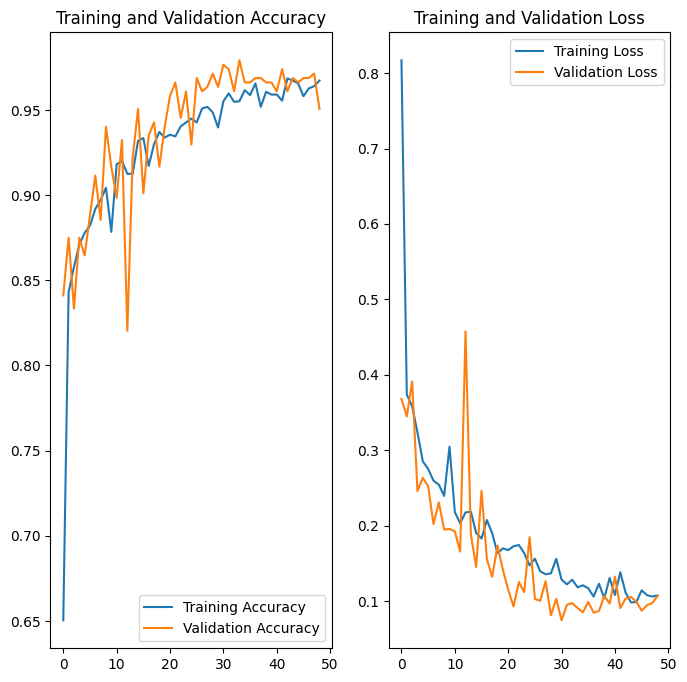

In [37]:
plt.figure(figsize=(8, 8))

plt.subplot(1,2,1)
plt.plot(range(n), acc, label='Training Accuracy')
plt.plot(range(n), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(n), loss, label='Training Loss')
plt.plot(range(n), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show

### Testing Trained Model

First image to predict
Actual label: Corn___Northern_Leaf_Blight
1/1 [==============================] - 0s 139ms/step
Predicted Label: Corn___Northern_Leaf_Blight


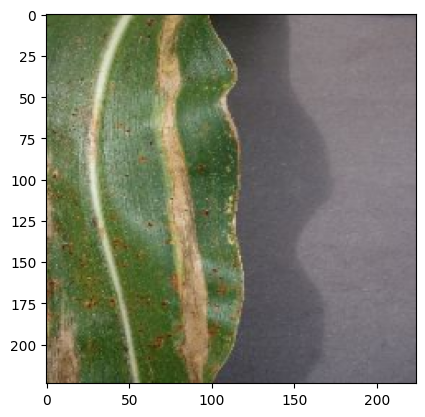

In [40]:
for images_batch, labels_batch in dataset.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("First image to predict")
    plt.imshow(first_image)
    print("Actual label:", class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("Predicted Label:", class_names[np.argmax(batch_prediction[0])])

In [41]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 19ms/step


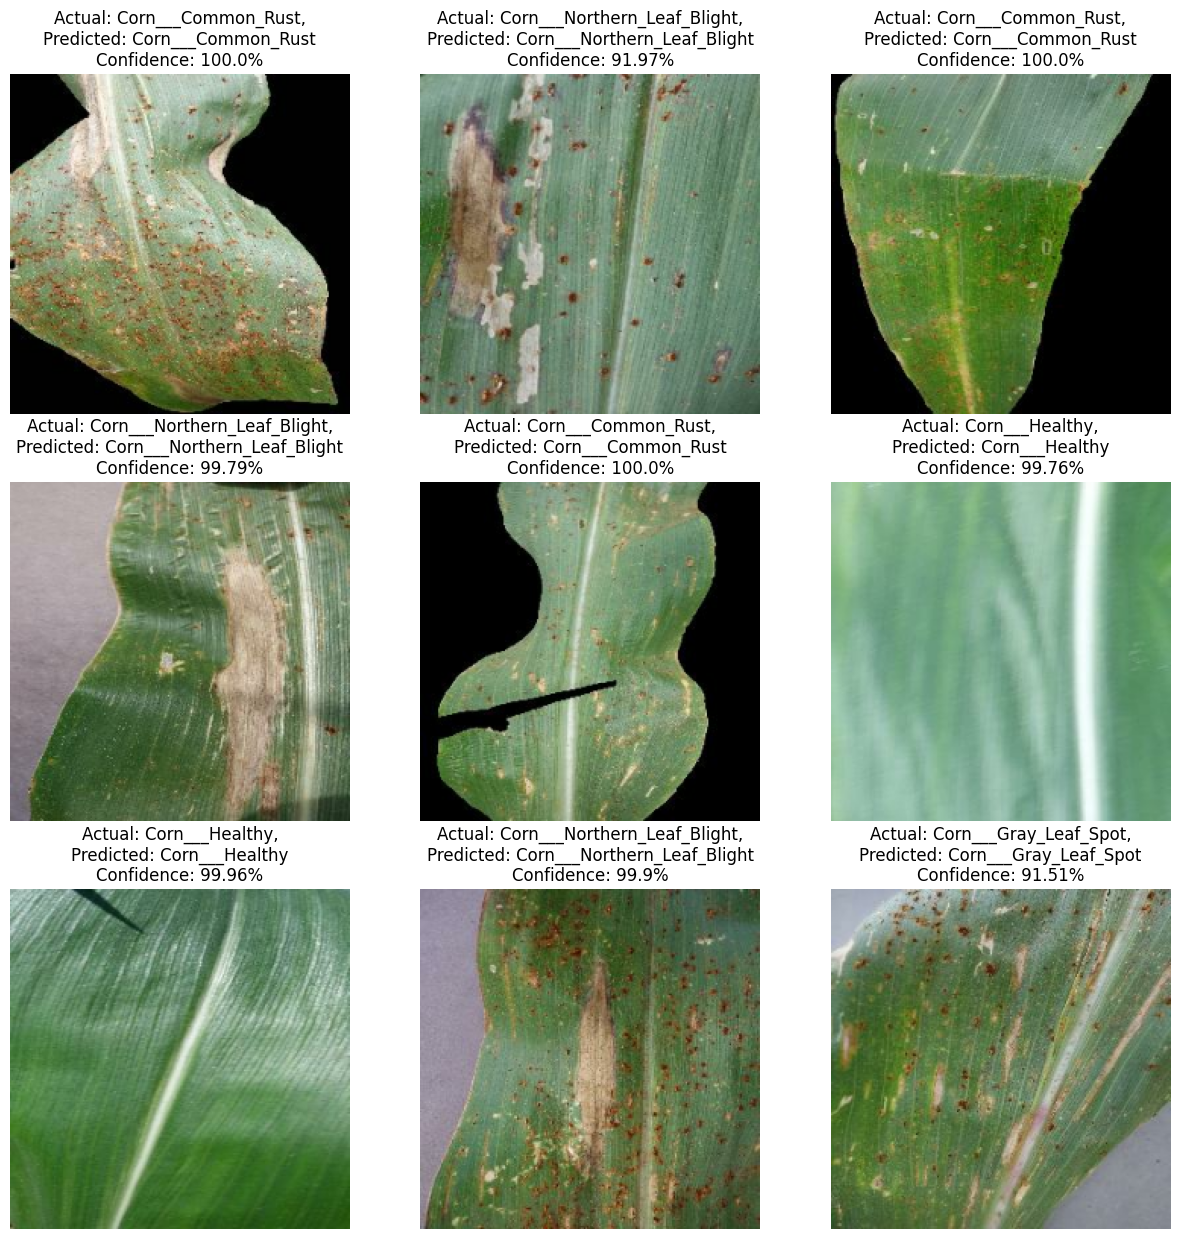

In [42]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class},\nPredicted: {predicted_class}\nConfidence: {confidence}%")
        plt.axis("off")

### Saving Model

In [44]:
model.save("./saved_models/corn_disease_model.h5")